In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path

2024-03-14 20:45:48.783461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Exercise: *Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label.*

**Note**: For large images, you could use `tf.io.encode_jpeg()` instead. This could save a lot of space, but it would lose a bit of image quality.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = (
    tf.keras.datasets.fashion_mnist.load_data()
)
X_train, y_train = X_train_full[5000:], y_train_full[5000:]
X_valid, y_valid = X_train_full[:5000], y_train_full[:5000]

In [3]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2024-03-14 20:45:50.692618: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
from tensorflow.train import BytesList, Int64List, Features, Feature, Example


def create_example(image, label) -> Example:
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

In [5]:
# Test create_example() function

for image, label in train_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000T\301\206Wi\\\217\203\000\000\001\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\006\350\343\325\363\377\377\356\351\362\305\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\262\366\276\316\353\340\351\362\321\277\337\234\027\000\000\002\000\000\000\000\000\000\000\000\000\000\000e\327\320\320\312\363\361\357\366\326\330\327\327\333c\000\000\000\000\000\000\000\000\000\000\000\000B\334\312\327\351\327\337\372\373\357\335\324\312\311\312\316\007\000\002\000\000\000\000\000\000\000\000\000\276\314\301\315\311\315\326\330\335\312\310\310\313\312\302\326W\000\002\000\000\000\000\000\000\000\000Z\333\305\300\271\300\301\277\276\275\276\262\247\271\274\301\323\251\000\000\000\000\000\000\000\000\000\000\243\330\306\303\304\304\301\300\305\311\306\262\236\270\304\316\327\300\000\

2024-03-14 20:45:50.781480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [55000]
	 [[{{node Placeholder/_1}}]]
2024-03-14 20:45:50.781653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [55000]
	 [[{{node Placeholder/_1}}]]


The following function does:
- Save a given dataset to a set of TFRecord files. The examples are written in a simple round-robin fashion.
- To do this, we enumerate over the dataset using the `enumerate()` method.
- We compute `index % n_shards` to decide which file to write to.

We use the standard `contextlib.ExitStack` class to make sure all writers are properly closed whether or not an I/O error occurs during writing.

In [6]:
from contextlib import ExitStack


def write_tfrecord(name, dataset, n_shards=10):
    paths = [
        "{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
        for index in range(n_shards)
    ]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path)) for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [7]:
train_filepaths = write_tfrecord(name="my_fashion_mnist.train", dataset=train_set)
valid_filepaths = write_tfrecord(name="my_fashion_mnist.valid", dataset=valid_set)
test_filepaths = write_tfrecord(name="my_fashion_mnist.test", dataset=test_set)

2024-03-14 20:45:50.904262: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


2024-03-14 20:45:50.918176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype uint8 and shape [55000]
	 [[{{node Placeholder/_5}}]]
2024-03-14 20:45:50.918574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype uint8 and shape [55000,28,28]
	 [[{{node Placeholder/_4}}]]
2024-03-14 20:46:02.845371: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2024-03-14 20:46:02.847918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and 

Exercise: *Then use tf.data to create an efficient dataset for each set.*

In [8]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1),
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]


def mnist(
    filepaths,
    n_read_threads=5,
    shuffle_buffer_size=None,
    n_parse_threads=None,
    seed=42,
    batch_size=32,
    cache=True,
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)

    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)

    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [9]:
train_set = mnist(train_filepaths, shuffle_buffer_size=60_000)
valid_set = mnist(valid_filepaths)
test_set = mnist(test_filepaths)

2024-03-14 20:46:05.734674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-14 20:46:05.735252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


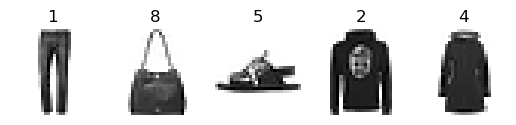

In [10]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.title(str(y[i].numpy()))
        plt.axis("off")

Exercise: *Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data.*

In [11]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(
    list(sample_image_batches.as_numpy_iterator()), axis=0
).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential(
    [
        standardization,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"]
)

2024-03-14 20:46:06.212842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-14 20:46:06.213281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


In [12]:
from datetime import datetime

logs = Path() / "my_logs" / "run" / datetime.now().strftime("%Y%m%d_%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10
)

model.fit(train_set, epochs=5, validation_data=valid_set, callbacks=[tensorboard_cb])

Epoch 1/5


2024-03-14 20:46:06.566217: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 20:46:06.566243: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 20:46:06.567097: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-03-14 20:46:06.592421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-14 20:46:06.592760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node P

     79/Unknown - 1s 3ms/step - loss: 0.8373 - accuracy: 0.7128

2024-03-14 20:46:07.187981: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-03-14 20:46:07.188007: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-03-14 20:46:07.191174: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-03-14 20:46:07.192534: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-03-14 20:46:07.192798: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: my_logs/run/20240314_204606/plugins/profile/2024_03_14_20_46_07/laptop-of-tan.xplane.pb


   1709/Unknown - 5s 2ms/step - loss: 0.4449 - accuracy: 0.8422

2024-03-14 20:46:11.469262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]
2024-03-14 20:46:11.469894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10]
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 5s 3ms/step - loss: 0.4450 - accuracy: 0.8422 - val_loss: 0.3752 - val_accuracy: 0.8680
Epoch 2/5
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3393 - accuracy: 0.8769 - val_loss: 0.3626 - val_accuracy: 0.8744
Epoch 3/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3003 - accuracy: 0.8899 - val_loss: 0.3305 - val_accuracy: 0.8832
Epoch 4/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2753 - accuracy: 0.8974 - val_loss: 0.3355 - val_accuracy: 0.8834
Epoch 5/5
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2582 - accuracy: 0.9031 - val_loss: 0.3242 - val_accuracy: 0.8878


In [20]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs